In [1]:
%matplotlib inline
from ocs_transmon import OCS
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import SymLogNorm

ocs = OCS(e_j_hz=8.335e9, e_c_hz=0.695e9) # WashU parameters

# Step-by-step Calculation

## Hamiltonian

The CPB Hamiltonian for the qubit alone starts from:
$$
\hat{H}_{\mathrm{CPB}}=4 E_C\left(\hat{n}-n_g+\frac{P-1}{4}\right)^2-E_J \cos \hat{\varphi}
$$

Note that here $\hat{\phi}$ is the conjugate opeartor (by postulation rather than an intuitive classical analogy) of $\hat{n}$: 

$$
[\hat{\phi}, \hat{n}] = i\hbar
$$

which leads to 

$$
\hat{n}\left(e^{i \hat{\varphi}}|n\rangle\right)=e^{i \hat{\varphi}}(n+1)|n\rangle=(n+1)\left(e^{i \hat{\varphi}}|n\rangle\right)
$$

Then one can rewrite the Hamiltonian by expanding $\cos \hat{\phi} = \frac{e^{\hat{\phi}} + e^{-\hat{\phi}}}{2}$:

$$
\hat{H}_{\mathrm{CPB}}=4 E_C\left(\hat{n}-n_g\right)^2 |n\rangle\langle n|-\left(E_J / 2\right)|n\rangle\langle n+1| + \text { h.c. }
$$

where the parity factor $\frac{P-1}{4}$ has been absorbed into $n_g$. Note that $n_g + \frac{1}{2}\rightarrow n_g$ stands for a single quasiparticle tunneling into the island.

This gives the Hamiltonian in the charge (number of Cooper pairs **deviated from a large average number**, which could have negative eigenvalues) basis $|n\rangle$. In principle, it should be infinite in dimensions of the matrix (Hilbert space), but here we force a truncation in dimension to make computation practical.



In [2]:
# n_g = 1/2
charge_cutoff = 10
h = ocs.build_hamiltonian(offset_charge=0.5, charge_cutoff=charge_cutoff) 
charge_states = np.arange(-charge_cutoff, charge_cutoff + 1)

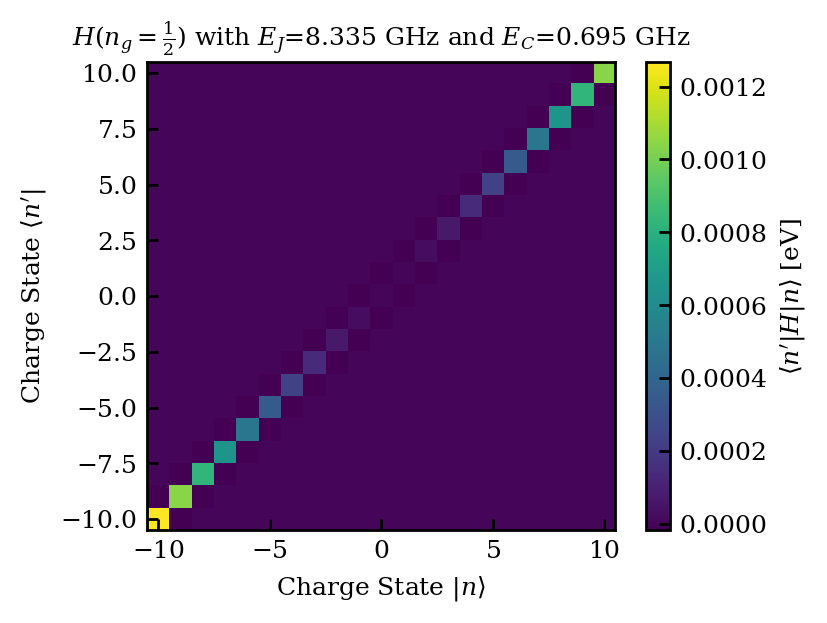

In [3]:
with plt.style.context(OCS._style_path):
    plt.figure(figsize=(4, 3))
    plt.imshow(h, origin='lower', vmin=h.min(), vmax=h.max(),
               extent=[charge_states[0]-0.5, charge_states[-1]+0.5,
                       charge_states[0]-0.5, charge_states[-1]+0.5])
    plt.xlabel('Charge State $|n\\rangle$')
    plt.ylabel('Charge State $\\langle n^\\prime |$')
    plt.colorbar(label='$\\langle n^\\prime |H|n\\rangle$ [eV]')
    plt.title('$H(n_g=\\frac{1}{2})$ with $E_J$=8.335 GHz and $E_C$=0.695 GHz', fontsize=9)
    plt.show()



## Energy Levels

Since $n_g + \frac{1}{2}\rightarrow n_g$ stands for a single quasiparticle tunneling into the island, the differnce between odd and even parity is simply $n_g$ (even) V.S. $n_g+\frac{1}{2}$ (even).

In [4]:
num_levels = 5
offset_charges = np.linspace(0, 1, 500)
energies_even, energies_odd, energy_diff = (
    ocs.solve_system(offset_charges, num_levels)
)

In [5]:
# axis 0: offset charge
# axis 1: energy level
np.shape(energies_even)

(500, 5)

Now we can show the energy difference between $i$-th excited state and the ground state for the qubit.

At offset charge 0:
Eⱼ/Eᴄ = 11.99
E₀₁ = 5.960 GHz
E₀₂ = 11.465 GHz
E₀₃ = 13.775 GHz
ΔE/Eᴄ = 0.0049


(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': '$\\xi=12.0$, $E_J=8.34$ GHz, $E_C=0.695$ GHz'}, xlabel='Offset Charge [$C_g V_g / 2e$]', ylabel='$f_{0i}$ [GHz]'>)

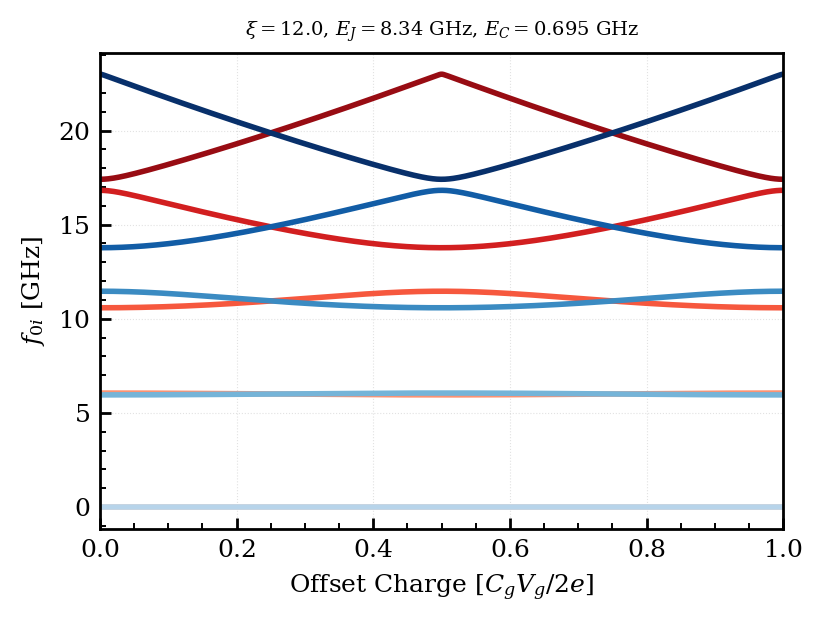

In [6]:
ocs.plot_energy_levels(offset_charges=offset_charges, num_levels=num_levels)

It seems that the parity matters little for the qubit at the first excited states. It is attempting to think about using the higher excited states for readout, but the very low lifetime (~ns) and negligible occupancy number (at ~20 mK) will disfavor this idea.

## Dispersive Coupling

So far we have said nothing about the resonator-qubit coupling. Following [Serniak et. al](https://arxiv.org/pdf/1903.00113), an OCS qubit coupled to a single linear readout mode is described by the following:

$$
\hat{H}=\hat{H}_{\mathrm{CPB}}+\hbar \omega_r \hat{a}^{\dagger} \hat{a}+\hbar g \hat{n}\left(\hat{a}+\hat{a}^{\dagger}\right)
$$ 

- $\omega_r$ is the bare readout mode frequency.
- $g$ is the capacitive coupling rate between the OCS qubit and the readout mode. In a classical picture, it should be determined by the electric dipole of the qubit and resonator electric field.
- $\hat{a}$ is the bosonic annihilation operator for excitations in the bare readout mode.

In the dispersive regime (on top of rotating wave approximation)
$$
g \ll |\omega_{0i} - \omega_r| \ll |\omega_{0i} + \omega_r|
$$

the coupling term $\hbar g \hat{n} (\hat{a} + \hat{a}^\dagger)$ produces a qubit-state-and-parity-dependent (labeled by $i$ for qubit energy level and parity by $p$) shift $\chi_{i,p}$ of the readout-mode $\omega_r$. This is computed by the second order perturbation theory:

$$
\chi_{i, p}=g^2 \sum_{j \neq i} \frac{\left.2 \omega_{i j, p}|\langle j, p| \hat{n}| i, p\right\rangle|^2}{\omega_{i j, p}^2-\omega_{\mathrm{r}}^2}
$$

where the matrix element $\langle j, p| \hat{n}| i, p\rangle$ is computed by:

In [7]:
matrix_elements, chi_ip = ocs.compute_dispersive_matrix(
    offset_charge=0.5, coupling_g_hz=150e6, readout_freq_hz=7.0e9, num_levels=6,
    parity='odd'
)

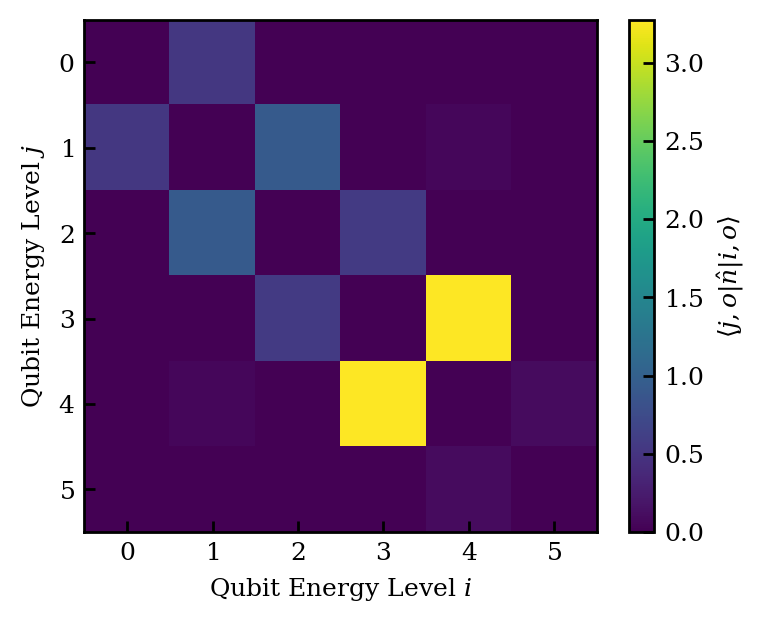

In [8]:
with plt.style.context(OCS._style_path):
    plt.figure(figsize=(4, 3))
    plt.imshow(matrix_elements)
    plt.colorbar(label='$\\langle j, o| \\hat{n}| i, o\\rangle$')
    plt.xlabel('Qubit Energy Level $i$')
    plt.ylabel('Qubit Energy Level $j$')
    plt.show()


(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': '$\\xi=12.0$, $E_J=8.34$ GHz, $E_C=0.695$ GHz, $g=150$ MHz'}, xlabel='Offset Charge [$C_g V_g / 2e$]', ylabel='$|\\langle j,o|\\hat{n}|0,o\\rangle|^2$'>)

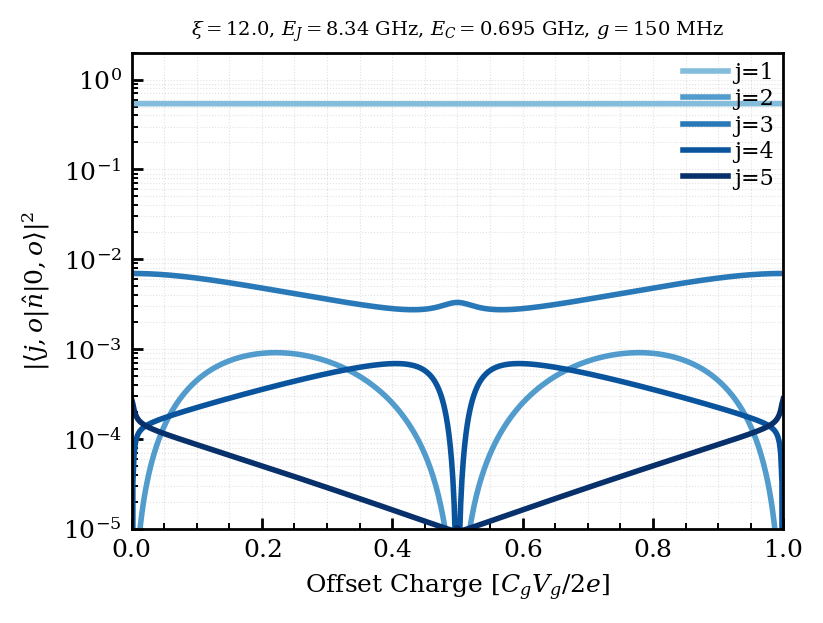

In [9]:
ocs.plot_matrix_elements(offset_charges, coupling_g_hz=150e6, readout_freq_hz=7.0e9, num_levels=6, parity='odd')

Above we show the odd parity case. One can imagine the shifting the odd curves by 1/2 in $n_g$ and you will get the even ones.

(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': '$\\xi=12.0$, $E_J=8.34$ GHz, $E_C=0.695$ GHz, $g=150$ MHz'}, xlabel='Offset Charge [$C_g V_g / 2e$]', ylabel='$|\\langle j,e|\\hat{n}|0,e\\rangle|^2$'>)

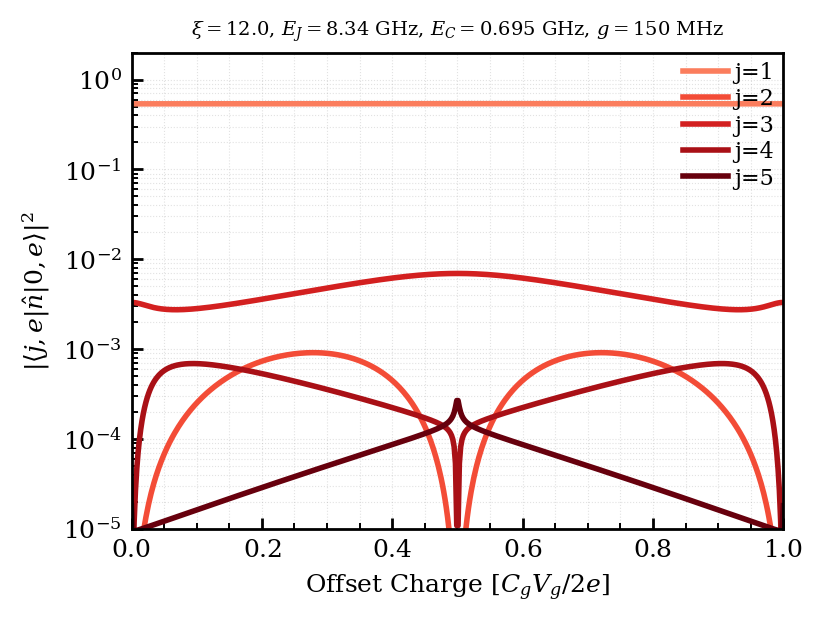

In [10]:
ocs.plot_matrix_elements(offset_charges, coupling_g_hz=150e6, readout_freq_hz=7.0e9, num_levels=6, parity='even')

With these matrix elements, we can now calculate the dispersive shifts $\chi_{i,p}$

(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': '$\\xi=12.0$, $E_J=8.34$ GHz, $E_C=0.695$ GHz, $g=150$ MHz'}, xlabel='Offset Charge [$C_g V_g / 2e$]', ylabel='$\\chi_{i,p}$ [MHz]'>)

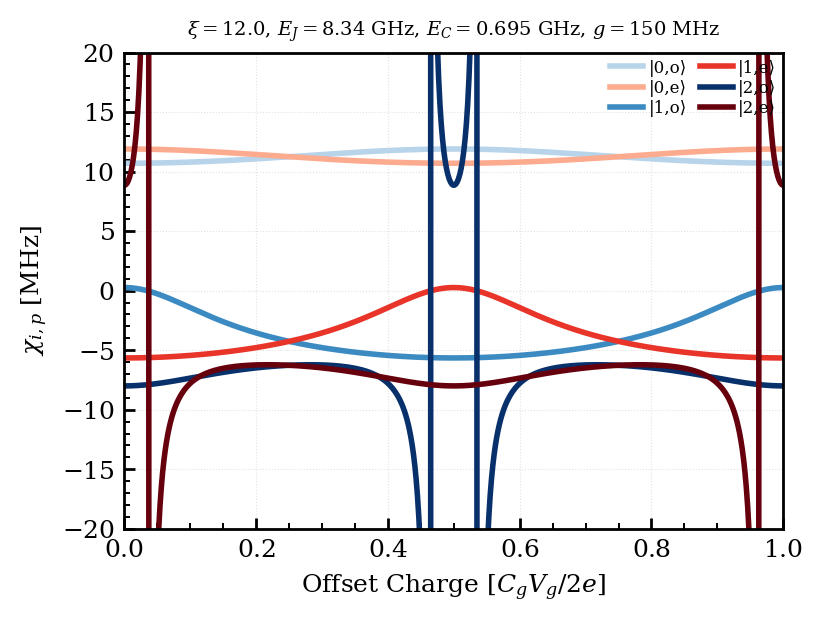

In [11]:
ocs.plot_dispersive_shift(
    offset_charges, coupling_g_hz=150e6, readout_freq_hz=7.0e9, num_levels=5,
    ylim=[-20, 20]
)

We only care about the difference between $|0,o\rangle$ and $|0, e\rangle$ above, which defines the figure of merit below. 


f_10: 6.009 GHz
f_20: 11.026 GHz
f_30: 15.300 GHz
Resonator frequency: 7.00 GHz
χ (resonator state shift): 73.721 MHz


(<Figure size 800x600 with 2 Axes>,
 (<Axes: title={'center': '$\\xi=12.0$, $E_J=8.34$ GHz, $E_C=0.695$ GHz, $g=150$ MHz'}, ylabel='$|\\chi_{0, o}-\\chi_{0, e}|$ [MHz]'>,
  <Axes: xlabel='Readout Frequency [GHz]', ylabel='$|f_r - f_{10}|/|f_r+f_{10}|$'>))

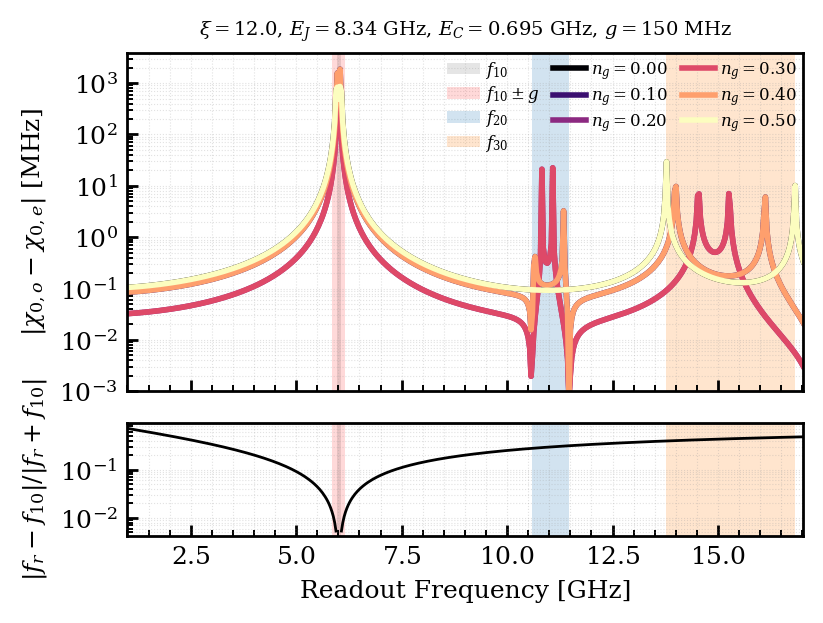

In [12]:
ocs.plot_parity_shift_vs_frequency(offset_charges=[0,0.1, 0.2, 0.3, 0.4, 0.5])

Note that we want to keep the readout frequency away the $f_{10}$ band to avoid breaking the dispersive requirement and RWA approximation.


f_10: 5.960 GHz


(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': '$\\xi=12.0$, $E_J=8.34$ GHz, $E_C=0.695$ GHz, $g=150$ MHz'}, xlabel='Offset Charge [$C_g V_g / 2e$]', ylabel='$|\\Delta\\chi_{0, o} - \\Delta\\chi_{0, e}|$ [MHz]'>)

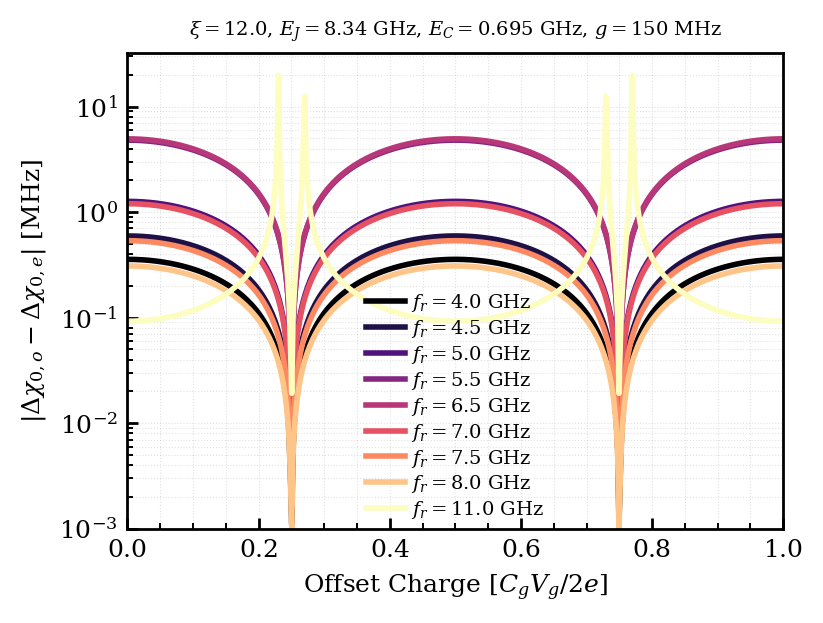

In [13]:
ocs.plot_parity_shift_vs_ng(
    readout_freqs=[4.0e9, 4.5e9, 5.0e9, 5.5e9, 6.5e9, 7.0e9, 7.5e9, 8.0e9, 11.0e9]
)

This is what you expect to see when running a sawtooth.

# Propagation to Measurements

How does this translate to $S_{21}$?
$$
S_{21}(f)=1-\frac{Q_r}{Q_c} \frac{1}{1+2 i Q_r \frac{f-f_r}{f_r}}
$$

In [14]:
def S21(f, fr, Qi, Qc):
    """
    Calculate the S21 transmission parameter for a coupled resonator.
    
    Parameters:
    -----------
    f : float or array-like
        Frequency (Hz)
    fr : float
        Resonance frequency (Hz)
    Qi : float
        Resonator intrinsic quality factor
    Qc : float
        Coupling quality factor
    
    Returns:
    --------
    complex or array of complex
        S21 transmission coefficient
    
    Formula:
    --------
    S21(f; fr) = 1 - (Qr/Qc) * 1/(1 + 2i*Qr*(f-fr)/fr)
    """
    # Convert inputs to numpy arrays for vectorized operations
    f = np.asarray(f)
    
    # Calculate the complex denominator
    Qr = 1/(1/Qi + 1/Qc)
    denominator = 1 + 2j * Qr * (f - fr) / fr
    
    # Calculate S21
    s21 = 1 - (Qr / Qc) * (1 / denominator)
    
    return s21

def fit_circle_complex(complex_array):
    """
    Fit a circle to an array of complex numbers in the complex plane.
    
    Parameters:
    -----------
    complex_array : array-like of complex numbers
        Array of complex numbers to fit a circle to
    
    Returns:
    --------
    dict
        Dictionary containing:
        - 'center': complex number representing circle center
        - 'radius': float representing circle radius
        - 'residuals': array of residuals for each point
        - 'rms_error': root mean square error of the fit
    
    Method:
    -------
    Uses algebraic circle fitting (Kasa method) which minimizes the sum of 
    squared algebraic distances from points to the circle.
    """
    # Convert to numpy array and extract real/imaginary parts
    z = np.asarray(complex_array)
    x = z.real
    y = z.imag
    
    # Number of points
    n = len(z)
    
    # Set up the linear system Ax = b for circle fitting
    # Circle equation: (x - xc)² + (y - yc)² = r²
    # Expanding: x² - 2*xc*x + xc² + y² - 2*yc*y + yc² = r²
    # Rearranging: 2*xc*x + 2*yc*y + (r² - xc² - yc²) = x² + y²
    
    # Matrix A: each row is [2*x, 2*y, 1]
    A = np.column_stack([2*x, 2*y, np.ones(n)])
    
    # Vector b: x² + y²
    b = x**2 + y**2
    
    # Solve the least squares problem
    try:
        # Use SVD for robust solution
        solution, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
        
        # Extract circle parameters
        xc = solution[0]  # x-coordinate of center
        yc = solution[1]  # y-coordinate of center
        c = solution[2]   # r² - xc² - yc²
        
        # Calculate radius
        radius = np.sqrt(c + xc**2 + yc**2)
        
        # Calculate residuals (distance from each point to the fitted circle)
        distances = np.sqrt((x - xc)**2 + (y - yc)**2)
        point_residuals = np.abs(distances - radius)
        
        # RMS error
        rms_error = np.sqrt(np.mean(point_residuals**2))
        
        return {
            'center': complex(xc, yc),
            'radius': radius,
            'residuals': point_residuals,
            'rms_error': rms_error,
            'fit_quality': 'good' if rms_error < 0.1 * radius else 'poor'
        }
        
    except np.linalg.LinAlgError:
        raise ValueError("Unable to fit circle - points may be collinear or insufficient data")


If we take the values of quality factors from recent QPD chip (QPD3): 


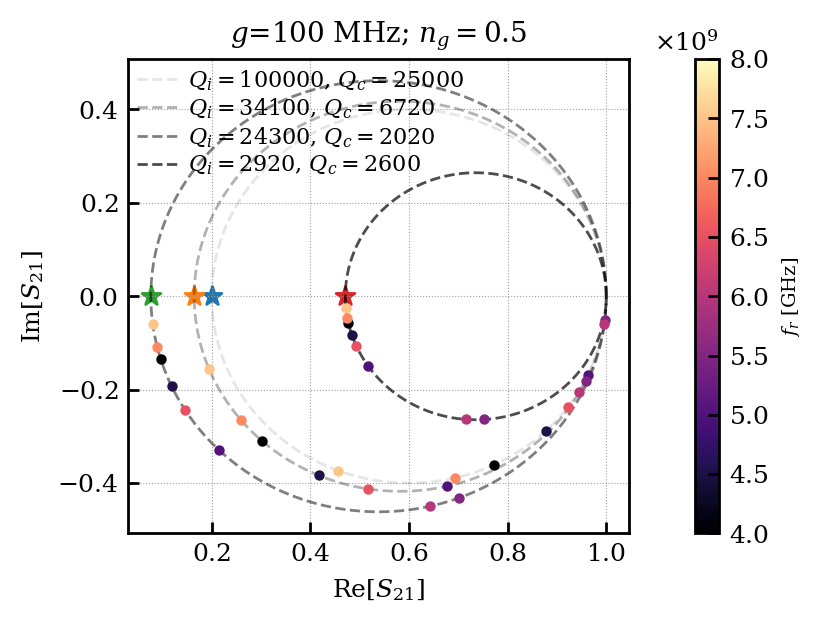

In [17]:
Qis = [100000, 34100, 24300, 2920]
Qcs = [25000, 6720, 2020, 2600]
frs = np.array([4.0e9, 4.5e9, 5.0e9, 5.5e9, 6.5e9, 7.0e9, 7.5e9, 8.0e9])
coupling_g_hz = 100e6

cmap = mp.colormaps.get_cmap('magma')
norm = plt.Normalize(vmin=frs.min(), vmax=frs.max())

with plt.style.context(OCS._style_path):
    plt.figure(figsize=(4, 3))
    for i in range(len(Qis)):
        Qi = Qis[i]
        Qc = Qcs[i]
        ring = S21(f=np.linspace(0, 9e10, 1000), fr=frs[0], Qi=Qi, Qc=Qc)
        fit_result = fit_circle_complex(ring)
        thetas = np.linspace(0, 2*np.pi, 1000)
        circle_x = fit_result['center'].real + fit_result['radius'] * np.cos(thetas)
        circle_y = fit_result['center'].imag + fit_result['radius'] * np.sin(thetas)
        plt.plot(circle_x, circle_y, ls="--", label=rf"$Q_i={Qi}$, $Q_c={Qc}$", color="black", alpha=0.1+i*0.2)
        S21zeros = S21(f=frs[0], fr=frs[0], Qi=Qi, Qc=Qc)
        plt.scatter(S21zeros.real,S21zeros.imag,marker='*',s=50)
        for j,fr in enumerate(frs):
            _, chi_odd = ocs.compute_dispersive_matrix(
                offset_charge=0.5, coupling_g_hz=coupling_g_hz, readout_freq_hz=fr, num_levels=6, parity='odd'
            )
            chi_odd = chi_odd[0]
            _, chi_even = ocs.compute_dispersive_matrix(
                offset_charge=0.5, coupling_g_hz=coupling_g_hz, readout_freq_hz=fr, num_levels=6, parity='even'
            )
            chi_even = chi_even[0]

            shifts =  (chi_odd - chi_even) * np.linspace(0, 1, 100)
            
            color = cmap(j/len(frs))
            s21zero = S21(f=fr,fr=fr,Qi=Qi,Qc=Qc)
            s21 = S21(f=fr, fr=fr+shifts[-1], Qi=Qi, Qc=Qc)
            plt.scatter(s21.real, s21.imag, color=color, s=30, zorder=10)

    plt.legend(loc="best")
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.set_label(r'$f_r$ [GHz]', fontsize=7)
    plt.xlabel(r"Re[$S_{21}$]")
    plt.ylabel(r"Im[$S_{21}$]")
    plt.title(r"$g$=100 MHz; $n_g=0.5$", fontsize=10)
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.show()

# From EPR to $g$

## Compute ZPF

Following [this helpful answer by Gemini](https://g.co/gemini/share/65be8cd13d03) to understand. [This](https://arxiv.org/pdf/2010.00620) is the full paper.

The EPR method (some finite-element method) finds the resonant frequencies of the linearized (i.e. JJ is replaced by a lump element where you specified capacitance and inductance by hardcoding) circuit. In our case, there will be two of interest: one for qubit (the lump element JJ) and one for reosonator (which may have more actually). By analogy to quantum harmonic oscillator, the frequencies can also be interpreted as zero point fluctuations (ZPF). 

More technically, it computes ZPFs starting from EPR $P_{m,j}$ quantifies how much of the total energy of mode $m$ (can be either qudit or resonator) is tored in the linearized junction $j$:

$$
P_{m, j}=\frac{\mathcal{E}_{J, j}^{(m)}}{\mathcal{E}_{\text {total }}^{(m)}}=\frac{\left\langle\psi_m\right| \frac{1}{2} L_J^{-1} \hat{\Phi}_j^2\left|\psi_m\right\rangle}{\left\langle\psi_m\right| \frac{1}{2} \hat{H}_{\text {lin }}\left|\psi_m\right\rangle}
$$

## Chi Matrix by `run_epr`

With the ZPFs obtained, `run_epr` can perform a numerical diagnoalization of the full Hamiltonian (with the nonlinear term $E_J \cos \left(\hat{\phi}_j\right)$). For two modes $m$ and $n$, the cross-Kerr term is extracted by quantifying the shift in mode $m$'s frequency caused by one excitation in mode $n$:

$$
\chi_{m n}\equiv\frac{1}{\hbar}\left[\left(E_{1_m, 1_n}-E_{0_m, 1_n}\right)-\left(E_{1_m, 0_n}-E_{0_m, 0_n}\right)\right]
$$

As a side note, $E_{1_m, 1_m}$ means two excitations (photons) in mode $m$.

These quantities define the Chi matrix (by ND). The Chi matrix, obtained via `run_epr`, represents the coefficients of the Kerr nonlinear coupling terms that dominate the effective Hamlitonian $\hat{H}_\mathrm{nl}$ when expressed in the normal mode Fock basis.

$$
\hat{H}_{\mathrm{nl}} \approx \sum_m \frac{\chi_{m, m}}{2} \hat{a}_m^{\dagger 2} \hat{a}_m^2+\sum_{m \neq n} \frac{\chi_{m n}}{2} \hat{a}_m^{\dagger} \hat{a}_m \hat{a}_n^{\dagger} \hat{a}_n
$$

It is clear that the diagnoal elements $\chi_{mm}$ represents the anharmonicity ($\alpha\equiv \omega_{12}-\omega_{10}$), and the off-diagonal term is the dispersive shift on resonator due to qubit (and vice versa when fliping index $nm\rightarrow mn$).

## Calculating $\chi$ from First Principle

In [the OCS paper](https://journals.aps.org/prapplied/pdf/10.1103/PhysRevApplied.12.014052) as well as the QPD paper, we were given that 
$$
\chi_{i, p} (\omega_r, n_g)=g^2 \sum_{j \neq i} \frac{\left.2 \omega_{i j, p}|\langle j, p| \hat{n}| i, p\right\rangle\left.\right|^ 2}{\omega_{i j, p}^2-\omega_{\mathrm{r}}^2}
$$

This is rigoroustly correct, with accuracy by second order perturabtion theory. 

It is also wroth noting the two common approximated version of it. First is the qubit (harmonic oscillator) approximation, which can be found in Naghiloo's thesis:

$$
\chi \approx \frac{g^2}{\Delta}
$$

This is corresponding to the case with huge anharmonicity, so the higher levels have no occupancies and qudits are well described by qubits.

The other common approximation is for transmon (used by [transmon qubit calculator]()):

$$
\chi \approx \frac{g^2}{\Delta}-\frac{g^2}{\Delta-E_C}
$$

Note that usually aharmonicity $\alpha\approx -E_C$. Compared to the full $\chi_{i,p}$, this made approximations including dominant transitions between the first two excited levels and the ground state. 